In [607]:
# Imports
import scipy
from scipy.signal import windows, welch
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

# Generating Data

In [608]:
def generate_data(random_state = 42):
    data = spectrum(
        sampling_rate=1000,
        duration=30,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=True
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

# Single Taper (Welch)

In [609]:
def single_taper_welch(signal, window_length, taper_shape, fs=1000):
    """
    Args: 
    - signal: signal, time domain 
    - window_length: in seconds
    - taper_shape: string, desired taper
    - fs: sampling frequency, default = 1000

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """
    nperseg = int(window_length * fs) # number of samples per segment

    freqs, psd = welch(signal,
                       fs=fs,
                       window=taper_shape,
                       nperseg=nperseg,
                       noverlap=0,
                       scaling='density' # return psd
                       )

    return freqs, psd

# Single Taper (No Welch)

In [610]:
def u_scaling(fft_result, taper, N): # https://www.mathworks.com/help/signal/ug/nonparametric-methods.html#f12-16152 
    # Scale the FFT results for single taper
    U = 1/N * sum(i**2 for i in taper)
    scaled_fft_single = [i/U for i in (fft_result)]
    return scaled_fft_single

def single_taper_no_welch(signal, window_length, taper_shape, fs=1000):
    """
    Args: 
    - signal: signal, time domain 
    - window_length: in seconds
    - taper_shape: string, desired taper
    - fs: sampling frequency, default = 1000

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """
    N = int(window_length * fs)  # number of samples in window
    signal = signal[-N:] # last window segment of signal
    tapered_signal = signal * windows.get_window(taper_shape, N)
    freqs = np.fft.rfftfreq(N, d=1/fs) # starting from 1 to avoid a divide by 0 error later.
    psd = ((np.abs(np.fft.rfft(tapered_signal)))**2) / (fs*N)
    psd[1:] *= 2
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]
    return freqs, u_scaling(psd, windows.get_window(taper_shape, N), N)


# Multitaper

In [611]:
def multitaper(signal, window_length, fs=1000, TW=1, K=1): # only TW and Window length
    """
    Args: 
    - signal: time domain 
    - window_length: size of window (in s)
    - fs: sampling frequency, default = 1000
    - TW: time bandwidth, default = 1
    - K: number of tapers, default = 1

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """

    N = int(window_length * fs)  # number of samples in window
    signal = signal[-N:] # first window segment of signal

    # default to 2*NW - 1 tapers
    K =  int(2 * TW - 1)

    # create dpss tapers
    tapers = dpss(N, TW, K)  # shape: (K, N)

    # Apply each taper to the signals
    # tapered_signals = np.zeros(len(tapers))  # shape: (K, N)
    # for i, taper in enumerate(tapers):
    #     fourier_coefficients = np.fft.fft(signal*taper)
    #     tapered_signals[i] = (fourier_coefficients * fourier_coefficients.conjugate()).real() 

    tapered_signals = np.array(
        [np.abs(np.fft.rfft(signal * taper)) ** 2 / (fs * N) for taper in tapers] 
    )# Convert to power  1 / (fs * N) * |FFT|^2 and divide by Welch normalization factor U = 1/L * Σ w(n)^2
    fft_sum = np.zeros_like(tapered_signals[0])  # Initialize sum of FFTs
    for i, taper in enumerate(tapers):
        fft_sum += u_scaling(tapered_signals[i], taper, N)
        
    psd = fft_sum / K  # Average PSD
    psd[1:] *= 2
    freqs = np.fft.rfftfreq(N, d=1/fs)

    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]

    return freqs, psd

# Multitaper Package

In [612]:
from spectral_connectivity import Multitaper, Connectivity 

def multitaper_package_implementation(signal, window_length, TW = 1, K = None, fs=1000):
    N = int(fs * window_length)
    x = signal[-N:] # obtain last chunk
    K = 1 #K or int(2 * TW - 1)  # default to 2*TW - 1 tapers if K is not specified
    mt = Multitaper(time_series = x, sampling_frequency = fs, time_halfbandwidth_product=TW, n_tapers = K)
    connectivity = Connectivity.from_multitaper(mt, expectation_type='tapers')
    freqs = connectivity.frequencies # dim:(250,)
    power = connectivity.power().reshape(N//2,)
    return freqs, power

# Example Run / Tangible Scaling Visualization Plot

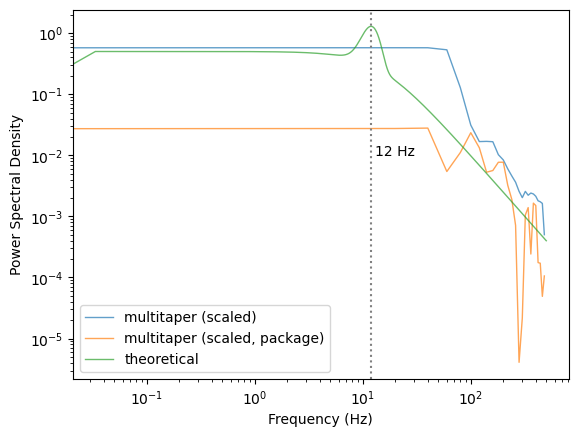

In [613]:
window_length = 0.05 # change window length

freq_hann, psd_hann = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hann')
freq_hamming, psd_hamming = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hamming')
freq_mt, psd_mt = multitaper(data_td, window_length=window_length, TW=4)
freq_mt_package, psd_mt_package = multitaper_package_implementation(data_td, window_length=window_length, TW=4)


#plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
#plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper (scaled)')
plt.loglog(freq_mt_package, psd_mt_package, linewidth=1, alpha=0.7, label='multitaper (scaled, package)')
plt.plot(data_fd.frequencies, data_fd.combined_spectrum, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Bias

In [614]:
# Calculate Bias

def calc_mean_bias(empiricalPSD, theoreticalPSD):
    N = len(theoreticalPSD)
    empiricalPSD = empiricalPSD[:-1] if (len(empiricalPSD) > N) else empiricalPSD
    biases = np.abs(empiricalPSD - theoreticalPSD) # do we need to change this cuz the empirical length is 251 while theoretical length is 250
    meanBias = np.sum(biases)/N

    return meanBias

In [615]:
def get_correct_theoretical_window(psd_theoretical_fd, freq_theoretical_fd, freq_empirical):
    """
    Interpolates theoretical PSD onto empirical frequency axis.
    """
    from scipy.interpolate import interp1d
    interpolator = interp1d(freq_theoretical_fd, psd_theoretical_fd, bounds_error=False, fill_value=np.nan)
    return interpolator(freq_empirical)

In [616]:
def calculate_biases(df, window_length, TW, data):
    for random_state in range(200): # generate data multiple times
        data = generate_data(random_state=random_state)
        data_td = data.time_domain.combined_signal
        data_fd = data.frequency_domain
        freq_hann, psd_hann = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hann')
        freq_hamming, psd_hamming = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hamming')
        freq_mt, psd_mt = multitaper(data_td, window_length=window_length, TW=TW)

        psd_theoretical_correct_window = get_correct_theoretical_window(data_fd.combined_spectrum, data_fd.frequencies, freq_hamming)
        psd_theoretical_correct_window_mt = get_correct_theoretical_window(data_fd.combined_spectrum, data_fd.frequencies, freq_mt)
        

        df.loc[len(df)] = [window_length,
                        TW,
                        calc_mean_bias(psd_hamming, psd_theoretical_correct_window),
                        calc_mean_bias(psd_hann, psd_theoretical_correct_window), 
                        calc_mean_bias(psd_mt, psd_theoretical_correct_window_mt)]
    return df

df = pd.DataFrame(columns=['window', 'TW', 'hamming_mean_bias', 'hann_mean_bias', 'multitaper_mean_bias'])
df = calculate_biases(df=df, window_length=0.01, TW=4, data=data)
df = calculate_biases(df=df, window_length=0.01, TW=1, data=data)
df = calculate_biases(df=df, window_length=0.05, TW=4, data=data)
df = calculate_biases(df=df, window_length=0.05, TW=1, data=data)
df = calculate_biases(df=df, window_length=0.1, TW=1, data=data)
df = calculate_biases(df=df, window_length=0.5, TW=1, data=data)
df = calculate_biases(df=df, window_length=0.1, TW=4, data=data)
df = calculate_biases(df=df, window_length=0.5, TW=4, data=data)

In [617]:
df.to_csv('taper_comparisons.csv', index=False)